In [1]:
#import packages and formatting statements

import numpy as np
import math
# !pip install matplotlib
from matplotlib import pyplot as plt
# !pip install astropy==5.3
import astropy.io.fits as pyfits
from astropy.table import Table, join, Column
from astropy.wcs import WCS
from astropy.io import ascii
import os
from astropy.coordinates import SkyCoord, Angle
from astropy.nddata import Cutout2D
import astropy.units as u
from astropy.visualization.wcsaxes import SphericalCircle
from matplotlib.patches import Circle
from reproject import reproject_interp

import sys
sys.path.append('./Python')
from CheckInImage import check_in_image
from AngularSize import findAngSize

plt.rc('text',usetex=False)
fontsize=10
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

ext="HA_FLUX_CORR"

In [2]:
# Compile galaxy and sne data
data = Table.read('../Data/1.GroupedSampleData.csv', format='csv')

data[0:1]

<Table length=1>
 col0  galaxy distance ... sn_type        sn_ra                sn_dec       
int64   str7  float64  ...  str50         str127               str132       
----- ------- -------- ... ------- ------------------- ---------------------
    0 NGC1087    15.85 ...  ['II'] [41.61152777777777] [-0.4987861111111111]

In [3]:
# get plot information for main image maps for the zooms
def getPlotStuff(gal, img, HSTimg, res, HIIimg, CO21Img, eCO21Img, names, types, ras, decs, dist, ext):
    plots, sigma, wcss, HIImaps, HSTmaps, HIIhst, hdus, dists, resolution = [],[],[],[],[],[],[],[],[]
    wcsHST, hduHST = [],[]
    SNnames, SNtypes, SNras, SNdecs, SNgals = [],[],[],[],[]

    for i in range(len(gal)):
        
        # ungroup and clean SN data
        sn_ra   = [float(x.strip(' []')) for x in ras[i].split(',')]
        sn_dec  = [float(x.strip(' []')) for x in decs[i].split(',')]
        sn_name = [x.strip(' []') for x in names[i].split(',')]
        sn_type = [x.strip(' []') for x in types[i].split(',')]
        
        for j in range(len(sn_name)):
            
            if os.path.isfile(img[i]) and os.path.isfile(HIIimg[i]):

                #get hdu & wcs for MUSE map
                ha_hdu = pyfits.open(img[i])
                hdus.append(ha_hdu)
                ha_map = ha_hdu[ext].data
                w = WCS(ha_hdu[ext].header, naxis=2)
                wcss.append(w)                
                plots.append(ha_map)
                resolution.append(res[i])
                
                #get HII maps
                hii_hdu = pyfits.open(HIIimg[i])
                hii_map = hii_hdu[0].data
                HIImaps.append(hii_map)
                
                #get HST map
                if os.path.isfile(HSTimg[i]):
                    hst_hdu = pyfits.open(HSTimg[i])
                    hst_map = hst_hdu[0].data
                    w = WCS(hst_hdu[0].header, naxis=2)
                    wHST = w      
                    hHST = hst_hdu
#                     hst_map, footprint = reproject_interp(hst_hdu, ha_hdu["HA_FLUX_CORR"].header)
                    hii_hst, footprint = reproject_interp(hii_hdu, hst_hdu[0].header)
                else: 
                    hst_map = np.full_like(ha_map, fill_value = float("NaN"))
                    hii_hst = np.full_like(ha_map, fill_value = float("NaN")) 
                    wHST = float("NaN")
                    hHST = float("NaN")
                
                HSTmaps.append(hst_map)
                HIIhst.append(hii_hst)
                wcsHST.append(w)
                hduHST.append(hHST)

                    
                # get CO contour map 
                if gal[i][0] == "NGC1672":
                    co_img = "../../GalaxyFiles/ALMACO2-1/ngc1672_7m+tp_co21_750pc_broad_mom0.fits"
                    co_err = "../../GalaxyFiles/ALMACO2-1/ngc1672_7m+tp_co21_750pc_broad_emom0.fits"
                else:
                    co_img = CO21Img[i]
                    co_err = eCO21Img[i]
                        
                co_hdu = pyfits.open(co_img)
                eco_hdu = pyfits.open(co_err)

                # reproject onto Halpha map
                co_repro_hdu, footprint = reproject_interp(co_hdu, ha_hdu["HA_FLUX_CORR"].header)
                eco_repro_hdu, footprint = reproject_interp(eco_hdu, ha_hdu["HA_FLUX_CORR"].header)

                # set up CO21 s/n map 
                co_map = co_repro_hdu
                err_map = eco_repro_hdu
                err_map = np.clip(err_map,0.01,np.max(err_map))
                sig_map = co_map / err_map
                sigma.append(sig_map)

                        
                # get rest of data
                SNnames.append(sn_name[j])
                SNtypes.append(sn_type[j])
                SNras.append(sn_ra[j]) 
                SNdecs.append(sn_dec[j])
                SNgals.append(gal[i])
                dists.append(dist[i])
                
#                 #Check if SN is in HII region
#                 xval, yval = w.wcs_world2pix(sn_ra[j],sn_dec[j], 0)
#                 xVal = int(xval)
#                 yVal = int(yval)
#                 HIIval = hii_map[yVal, xVal]

#                 if HIIval < 0:
#                     inHII.append("No ")
#                 else:
#                     inHII.append("Yes ")

            else:
                #print("no file for ")
                pass

    return(plots, sigma, wcss, HIImaps, HSTmaps, HIIhst, hdus, wcsHST, hduHST, SNnames, SNtypes, SNras, SNdecs, SNgals, dists, resolution)


In [4]:
# set up plot information for MUSE zooms
# set up plots, wcs information, and HII maps for contours.

plots, sigma, wcss, HIImaps, HSTmaps, HIIhst, hdus, wcsHST, hduHST, sn_names, sn_types, sn_ras, sn_decs, sn_gals, dists, res = getPlotStuff(data["galaxy"], data["maps_nat"], data["maps_HST"],data["nat_res"], data["maps_HII"], data["maps_CO21"], data["maps_eCO21"], data["sn_name"], data["sn_type"], data["sn_ra"], data["sn_dec"], data["distance"], ext=ext)


In [5]:
#set up labels for legends
legendLabels = []

for i in range(len(sn_names)):
    legendlabel = []
    if sn_types[i][0] == 'unclassified':
        legendlabel.append(sn_names[i].strip("'") + ' '  + sn_types[i].strip("'")) 
    else:        
        legendlabel.append(sn_names[i].strip("'") + ' Type '  + sn_types[i].strip("'"))
    legendLabels.append(legendlabel)

# print(legendLabels[0])


In [6]:
resPC = [71,82,109,109,109,109,82,69,69,69,90,90,58,58,58,58,58,57,57,57,57,64,64,64,64,64,64,64,85,85,85,85,85]
len(resPC)

33

/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_89534/3557481482.py:23: RuntimeWarning: divide by zero encountered in log10
  logData = np.log10(data)


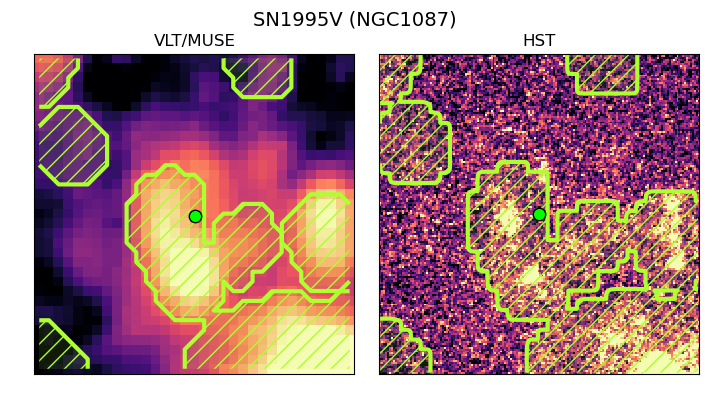

In [7]:
plt.rcParams['hatch.color'] = 'greenyellow'
numPixels, numHIIPixels = [],[]

current_cmap = plt.get_cmap("magma")
current_cmap.set_bad("black")

NUM_SNE= 33

fig, axs = plt.subplots(1,2,figsize=(7,4))

# for j in range(len(sn_gals)): # counter to count galaxy maps
for j in range(0,1):
    
    #set up legend label with type classification
    if sn_types[j] != "Unclassified":
        leglab = "Type " + sn_types[j].strip("'")
    else:
        leglab= sn_types[j]
    legStr = str(resPC[j]) + " pc"
    
    #set up data to use astropy's cutout2D to plot subsections of galaxy map
    data = plots[j]
    logData = np.log10(data)
    HIIData = HIImaps[j]
    HSTdata = HSTmaps[j]
#     sigData = sigma[j]
    HIIhstData = HIIhst[j]

    wcs=wcss[j]

    halfBox = findAngSize(500,dists[j])/2. # 500 pc in decimal degrees/2?
    #cutout2D needs skycoord position to carry units
    ra, dec = Angle(sn_ras[j] * u.degree), Angle(sn_decs[j] * u.degree)
    raRad, decRad  = ra.radian * u.rad, dec.radian * u.rad    
    position = SkyCoord(raRad, decRad) #position is center, use ra & dec of SN location
    size = u.Quantity((findAngSize(500,dists[j]),findAngSize(500,dists[j])), u.degree) #size is size of box in arcsec 
    # make 2D cutout, will assign a new wcs to cutout to keep track of coords
    cutout = Cutout2D(logData, position, size, wcs) 
    # use this new wcs when converting to pixels to add additional details to plot
    xval, yval = cutout.wcs.wcs_world2pix(ra,dec, 0)
    # get HII data for contours
    HIICutout = Cutout2D(HIIData, position, size, wcs)
#     sigCutout = Cutout2D(sigData, position, size, wcs)
    HIICutoutHST = Cutout2D(HIIhstData, position, size, wcsHST[j])
#     sigCutoutHST = Cutout2D(sigData, position, size, wcsHST[j])    
    HSTCutout = Cutout2D(HSTdata, position, size, wcsHST[j])
    xvalHST, yvalHST = HSTCutout.wcs.wcs_world2pix(ra,dec, 0)

    titleStr = sn_names[j].upper().strip("'") + " (" + sn_gals[j].upper() + ")"
            
    # make plot
    fig.suptitle(titleStr, fontsize=14) 
    axs[0].set_title("VLT/MUSE")
    axs[0].imshow(cutout.data, cmap=current_cmap, aspect="equal", origin = "lower", vmin=np.percentile(cutout.data, 5), vmax=np.percentile(cutout.data, 95),interpolation = "nearest", zorder = 0)
    axs[0].scatter(xval, yval, color = "black", marker ="o", s = 60, zorder=2)
    axs[0].scatter(xval, yval, color = "lime", marker = "o", s = 80, edgecolor="black",zorder = 2, label=leglab)
    axs[0].set_ylabel(" ")
    axs[0].set_xlabel(" ")
    axs[0].set_xticklabels([])
    axs[0].set_yticklabels([])
    axs[0].tick_params(axis = "both", direction = "in", length = 0)
    axs[1].set_title("HST")
    axs[1].imshow(HSTCutout.data, cmap=current_cmap, aspect="equal", origin = "lower", vmin=np.percentile(HSTCutout.data, 5), vmax=np.percentile(HSTCutout.data, 95),interpolation = "nearest", zorder = 0)
    axs[1].scatter(xvalHST, yvalHST, color = "black", marker ="o", s = 60, zorder=2)
    axs[1].scatter(xvalHST, yvalHST, color = "lime", marker = "o", s = 80, edgecolor="black",zorder = 2, label=leglab)
    axs[1].set_ylabel(" ")
    axs[1].set_xlabel(" ")
    axs[1].set_xticklabels([])
    axs[1].set_yticklabels([])
    axs[1].tick_params(axis = "both", direction = "in", length = 0)
    

    axs[0].contourf(HIICutout.data, [3,1000000], colors = ["greenyellow"], linestyles = ("-"), hatches=['//'], zorder = 1, alpha=0.1)
    axs[0].contour(HIICutout.data, [3], colors = ["greenyellow"], linestyles = ("-"), linewidths=3, zorder = 1)
    
    axs[1].contourf(HIICutoutHST.data, [3,1000000], colors = ["greenyellow"], linestyles = ("-"), hatches=['//'], zorder = 1, alpha=0.1)
    axs[1].contour(HIICutoutHST.data, [3], colors = ["greenyellow"], linestyles = ("-"), linewidths=3, zorder = 1)

plt.tight_layout(pad=0.4, w_pad=0, h_pad=0.2)
plt.show()
fig.savefig("../Figures/HST_MUSE_Comp.png", dpi=300)
plt.close()

0
Type II
1
Type II
2
Type Ia
3
4
Type Ic
5
6
Type II
7
Type Ia
8
Type Ia-02cx
9
Type II
10
Type II
11
Type Ib/c


/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_89534/1155304628.py:23: RuntimeWarning: divide by zero encountered in log10
  logData = np.log10(data)
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_89534/1155304628.py:80: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in leg.legendHandles:
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_89534/1155304628.py:23: RuntimeWarning: divide by zero encountered in log10
  logData = np.log10(data)
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_89534/1155304628.py:23: RuntimeWarning: divide by zero encountered in log10
  logData = np.log10(data)
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_89534/1155304628.py:80: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_ha

12
13
Type Ia
14
Type II P
15
Type II
16
17
18
19
20
Type Ic
21
22
23
24
25
26
27
28
Type Ia
29
Type I
30
31
Type Ic
32
Type Ib


/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_89534/1155304628.py:23: RuntimeWarning: divide by zero encountered in log10
  logData = np.log10(data)
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_89534/1155304628.py:80: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in leg.legendHandles:
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_89534/1155304628.py:23: RuntimeWarning: divide by zero encountered in log10
  logData = np.log10(data)
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_89534/1155304628.py:23: RuntimeWarning: divide by zero encountered in log10
  logData = np.log10(data)
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_89534/1155304628.py:80: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_ha

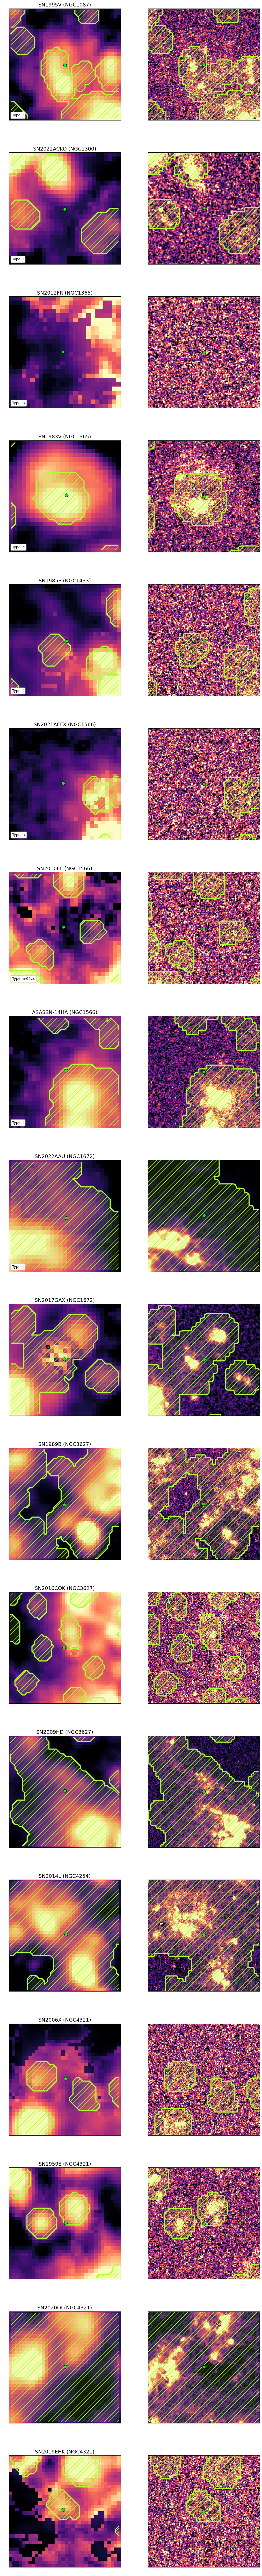

In [31]:

comp = [0,1,2,4,6,7,8,9,10,11,13,14,15,20,28,29,31,32]

fig, axs = plt.subplots(len(comp),2,figsize=(10,100))

l,n,m,p=0,0,0,0
PLOTS_PER_ROW = 2

for j in range(len(sn_gals)): # counter to count galaxy maps
# for j in range(0,1):
    print(j)
    if j in comp:

        #set up legend label with type classification
        if sn_types[j] != "Unclassified":
            leglab = "Type " + sn_types[j].strip("'")
        else:
            leglab= sn_types[j]
        print(leglab)
        legStr = str(resPC[j]) + " pc"

        #set up data to use astropy's cutout2D to plot subsections of galaxy map
        data = plots[j]
        logData = np.log10(data)
        HIIData = HIImaps[j]
        HSTdata = HSTmaps[j]
    #     sigData = sigma[j]
        HIIhstData = HIIhst[j]

        wcs=wcss[j]

        halfBox = findAngSize(500,dists[j])/2. # 500 pc in decimal degrees/2?
        #cutout2D needs skycoord position to carry units
        ra, dec = Angle(sn_ras[j] * u.degree), Angle(sn_decs[j] * u.degree)
        raRad, decRad  = ra.radian * u.rad, dec.radian * u.rad    
        position = SkyCoord(raRad, decRad) #position is center, use ra & dec of SN location
        size = u.Quantity((findAngSize(500,dists[j]),findAngSize(500,dists[j])), u.degree) #size is size of box in arcsec 
        # make 2D cutout, will assign a new wcs to cutout to keep track of coords
        cutout = Cutout2D(logData, position, size, wcs) 
        # use this new wcs when converting to pixels to add additional details to plot
        xval, yval = cutout.wcs.wcs_world2pix(ra,dec, 0)
        # get HII data for contours
        HIICutout = Cutout2D(HIIData, position, size, wcs)
    #     sigCutout = Cutout2D(sigData, position, size, wcs)
        HIICutoutHST = Cutout2D(HIIhstData, position, size, wcsHST[j])
    #     sigCutoutHST = Cutout2D(sigData, position, size, wcsHST[j])    
        HSTCutout = Cutout2D(HSTdata, position, size, wcsHST[j])
        xvalHST, yvalHST = HSTCutout.wcs.wcs_world2pix(ra,dec, 0)

        titleStr = sn_names[j].upper().strip("'") + " (" + sn_gals[j].upper() + ")"

        # make plot
        axs[l][0].set_title(titleStr, fontsize=14)      
        axs[l][0].imshow(cutout.data, cmap=current_cmap, aspect="equal", origin = "lower", vmin=np.percentile(cutout.data, 5), vmax=np.percentile(cutout.data, 95),interpolation = "nearest", zorder = 0)
        axs[l][0].scatter(xval, yval, color = "black", marker ="o", s = 60, zorder=2)
        axs[l][0].scatter(xval, yval, color = "lime", marker = "o", s = 80, edgecolor="black",zorder = 2, label=leglab)
        axs[l][0].set_ylabel(" ")
        axs[l][0].set_xlabel(" ")
        axs[l][0].set_xticklabels([])
        axs[l][0].set_yticklabels([])
        axs[l][0].tick_params(axis = "both", direction = "in", length = 0)
        
        axs[l][1].imshow(HSTCutout.data, cmap=current_cmap, aspect="equal", origin = "lower", vmin=np.percentile(HSTCutout.data, 5), vmax=np.percentile(HSTCutout.data, 95),interpolation = "nearest", zorder = 0)
        axs[l][1].scatter(xvalHST, yvalHST, color = "black", marker ="o", s = 60, zorder=2)
        axs[l][1].scatter(xvalHST, yvalHST, color = "lime", marker = "o", s = 80, edgecolor="black",zorder = 2, label=leglab)
        axs[l][1].set_ylabel(" ")
        axs[l][1].set_xlabel(" ")
        axs[l][1].set_xticklabels([])
        axs[l][1].set_yticklabels([])
        axs[l][1].tick_params(axis = "both", direction = "in", length = 0)


        axs[l][0].contourf(HIICutout.data, [3,1000000], colors = ["greenyellow"], linestyles = ("-"), hatches=['//'], zorder = 1, alpha=0.1)
        axs[l][0].contour(HIICutout.data, [3], colors = ["greenyellow"], linestyles = ("-"), linewidths=3, zorder = 1)
        axs[l][1].contourf(HIICutoutHST.data, [3,1000000], colors = ["greenyellow"], linestyles = ("-"), hatches=['//'], zorder = 1, alpha=0.1)
        axs[l][1].contour(HIICutoutHST.data, [3], colors = ["greenyellow"], linestyles = ("-"), linewidths=3, zorder = 1)

        l+=1
        if n == 0:
            leg = axs[m][n].legend(handlelength=0, handletextpad=0, loc="lower left", facecolor='white', framealpha=1.0)
            for item in leg.legendHandles:
                item.set_visible(False)

        n+=1
        if n%PLOTS_PER_ROW==0:
            m+=1
            n=0
        p +=1
    else:pass

    plt.subplots_adjust(left = 0.1, bottom = 0.1, right = 0.99, top = 0.9, wspace = 0.3, hspace = 0.2)
plt.tight_layout(pad=0.5, w_pad=6.8, h_pad=1.0)
plt.show()
fig.savefig("../Figures/MUSE_HST_Zooms_500pc.png", dpi=300)
plt.close()

In [12]:
[0,1,2,4,6,7,8,9,10,11,13,14,15,20,28,29,31,32]

(230, 230)


In [13]:
print(HIICutout.shape)

(46, 46)


In [14]:
print(HSTCutout.shape)

(230, 230)


In [30]:
leglab

'Type Ib'